In [28]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq
from scipy.signal import butter, lfilter, find_peaks

# Define the bandpass filter parameters
lowcut = 0.75  # Lower cutoff frequency in Hz
highcut = 2.5  # Upper cutoff frequency in Hz
fs = 30  # Sampling frequency, adjust accordingly based on your data

# Normalize the cutoff frequencies
low = lowcut / (0.5 * fs)
high = highcut / (0.5 * fs)

# Design a Butterworth bandpass filter
b, a = butter(N=1, Wn=[low, high], btype='band')

def get_heart_rate(channel, window_size=180, step_size=60, sampling_rate=30):
    # Calculate the number of windows
    num_windows = (len(channel) - window_size) // step_size + 1

    # Initialize lists to store peak frequencies and corresponding amplitudes
    all_peaks = []
    all_hr = []

    # Initialize time values
    time_values = []

    for i in range(num_windows):

        # Extract the current window
        window_start = i * step_size
        window_end = window_start + window_size
        window = channel[window_start:window_end]

        # Perform FFT on the window
        fft_result = fft(window)
        freq = fftfreq(len(fft_result)) * sampling_rate
        
        # Convert the frequency domain to below 2.5Hz and above 0.75Hz
        fft_result = fft_result[(freq < 2.5) & (freq > 0.75)]
        freq = freq[(freq < 2.5) & (freq > 0.75)]

        # Normalize the signals
        fft_result = fft_result / np.max(np.abs(fft_result))

        # Find peaks in the magnitude spectrum within the specified range
        peaks, _ = find_peaks(np.abs(fft_result), height=0)

        # Sort the peaks by amplitude in descending order
        sorted_peaks = sorted(peaks, key=lambda x: np.abs(fft_result[x]), reverse=True)
        
        # Store the frequency and amplitude of the first peak in each window
        if sorted_peaks:
            peak_frequency = freq[sorted_peaks[0]]
            all_hr.append(peak_frequency * 60)
        else:
            all_hr.append(all_hr[-1])

        # Calculate time value for the center of the window
        time_values.append((window_start + window_end) / 2)

    return all_hr

In [29]:
def predict_hr(video, window_size=180, step_size=90):
    # Create a list to store the extracted face ROIs and frame timestamps
    face_rois = []
    forehead_rois = []
    timestamps = []

    # Load the pre-trained face cascade
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    
    count = 0
    # Iterate through the frames in the video array
    for frame in video:
        # Convert the frame to 8-bit unsigned integer
        frame = cv2.normalize(frame, None, 0, 255, cv2.NORM_MINMAX)
        frame = frame.astype(np.uint8)

        # Convert the frame to grayscale
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        # Detect faces in the image
        faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

        if len(faces) > 0:
            for (x, y, w, h) in faces:
                cv2.rectangle(frame, (x, y), (x+w, y+h), (255, 0, 0), 1)

                # Define ROI for the face
                face_roi = frame[y:y+h, x:x+w]
                face_roi_resized = cv2.resize(face_roi, (100, 100))
                face_rois.append(face_roi_resized)

                # Define ROI for the forehead (adjust the coordinates based on your preference)
                forehead_roi = frame[y:y+int(h*0.3), x+int(w*0.2):x+int(w*0.8)]

                forehead_roi_resized = cv2.resize(forehead_roi, (100, 30))
                forehead_rois.append(forehead_roi_resized)

                # Draw rectangles around the face and forehead regions
                cv2.rectangle(frame, (x+int(w*0.2), y), (x+int(w*0.8), y+int(h*0.3)), (0, 255, 0), 1)

        else:
            forehead_rois.append(forehead_rois[-1])
            
        count += 1

        if count == 1:
            # Display the original image with detected face and forehead ROIs
            plt.imshow(cv2.cvtColor(frame, cv2.IMREAD_COLOR))

        # Get the frame timestamp based on a fixed sampling rate (e.g., 30 frames per second)
        timestamp = len(timestamps) / 30.0  # Assuming 30 frames per second
        timestamps.append(timestamp)
        
    # Convert the list of face ROIs to a NumPy array
    forehead_rois_np = np.array(forehead_rois)

    # Check if there are forehead ROIs available
    if len(forehead_rois_np) == 0:
        print("No forehead ROIs detected.")
    else:
        # Calculate average color over time for each pixel in the face ROI
        average_color = np.mean(forehead_rois_np, axis=(1, 2), dtype=np.float64)

        green_channel = average_color[:, 1]

        # Apply the bandpass filter to the green channel data
        green_channel = lfilter(b, a, green_channel) 

        predicted_hr = get_heart_rate(green_channel, window_size=window_size, step_size=step_size)

        return predicted_hr

Filename: p29_0.mat
First frame:


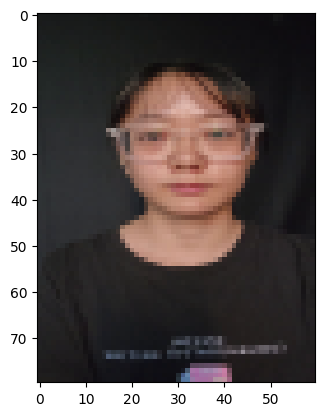

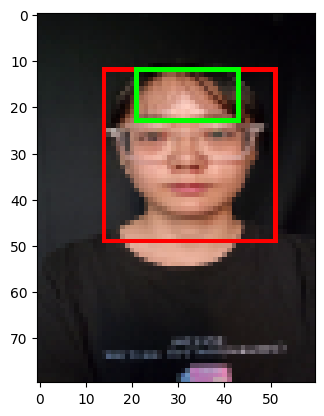

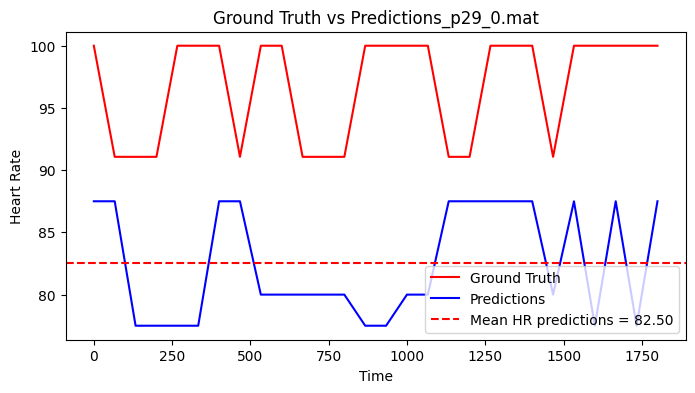

Mean Absolute Error (MAE)_p29_0.mat: 14.311224489795913
Filename: p29_4.mat
First frame:


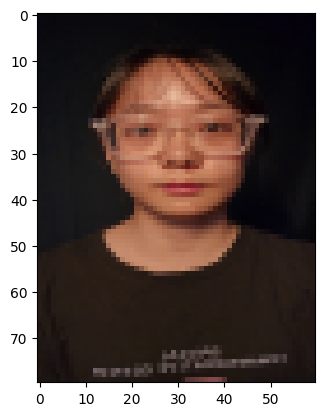

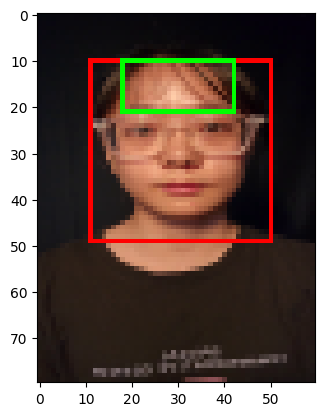

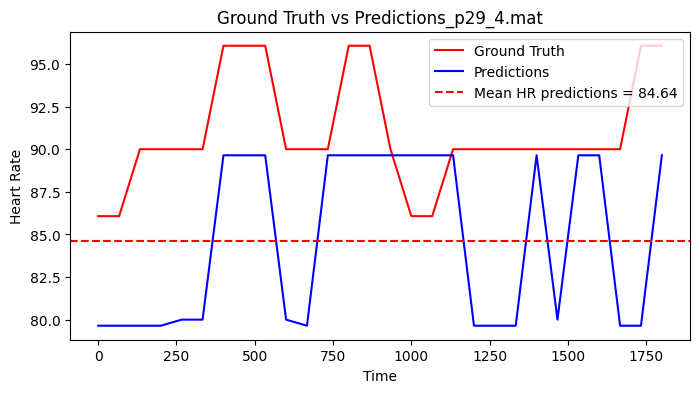

Mean Absolute Error (MAE)_p29_4.mat: 6.77295918367347
Filename: p6_8.mat
First frame:


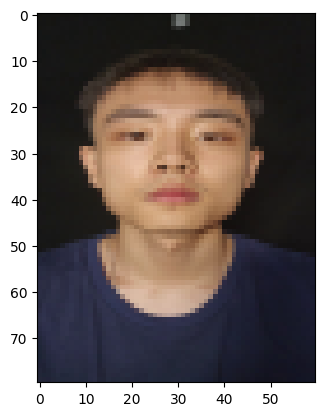

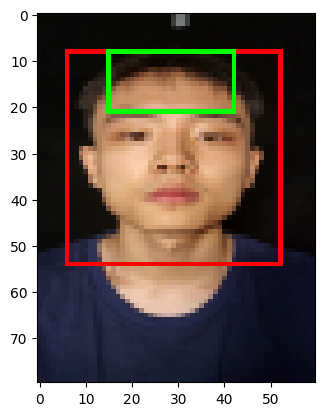

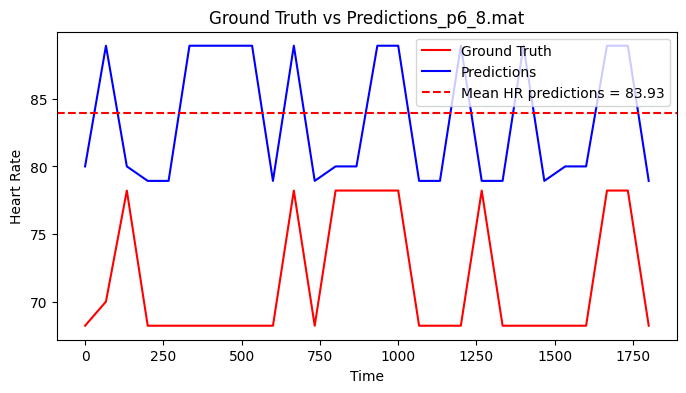

Mean Absolute Error (MAE)_p6_8.mat: 11.95153061224491
Filename: p6_4.mat
First frame:


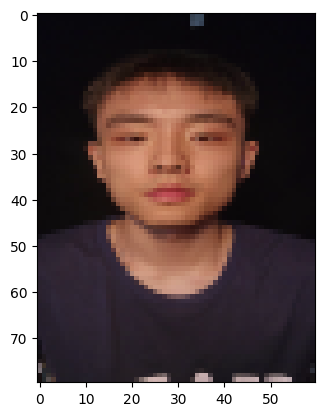

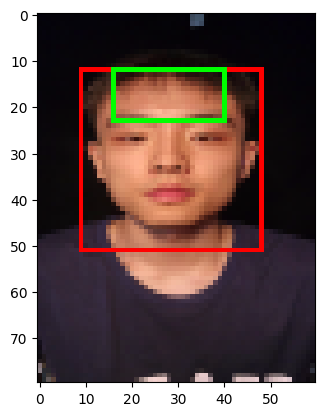

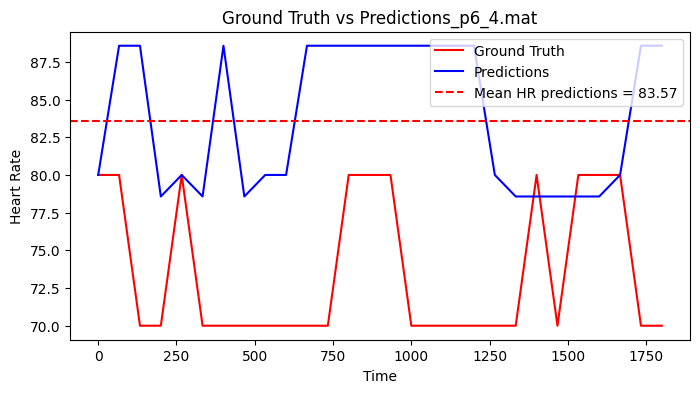

Mean Absolute Error (MAE)_p6_4.mat: 10.612244897959185
Filename: p29_8.mat
First frame:


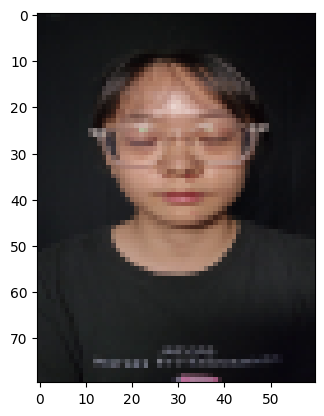

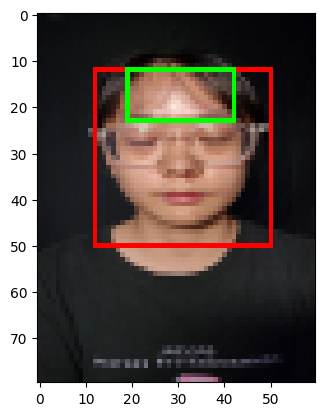

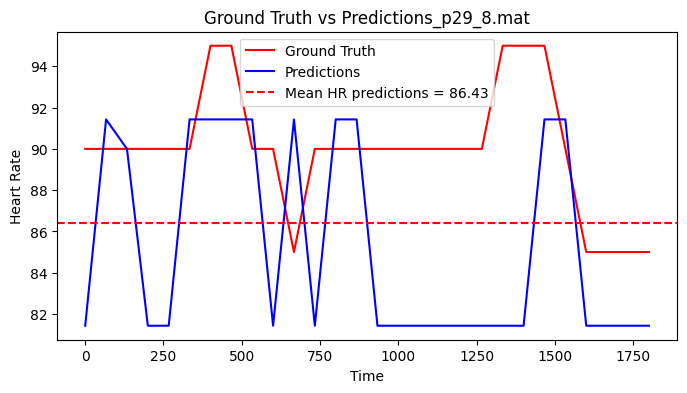

Mean Absolute Error (MAE)_p29_8.mat: 5.765306122448976
Filename: p6_0.mat
First frame:


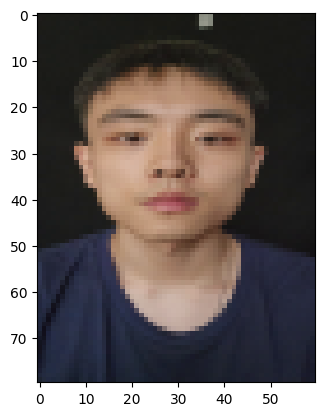

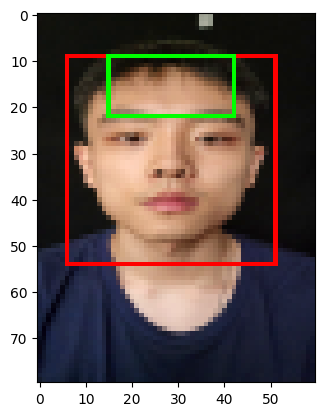

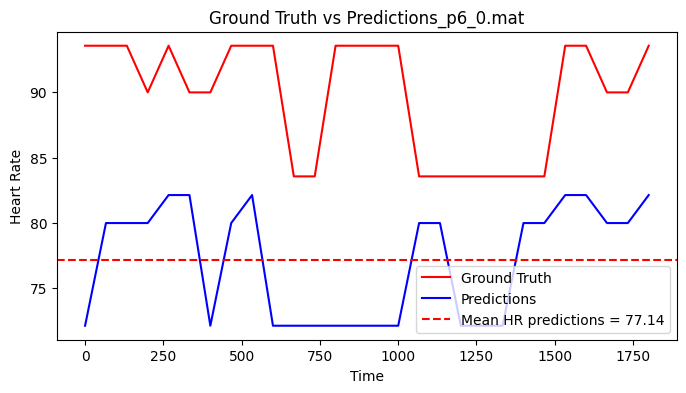

Mean Absolute Error (MAE)_p6_0.mat: 12.627551020408161
Filename: p29_16.mat
First frame:


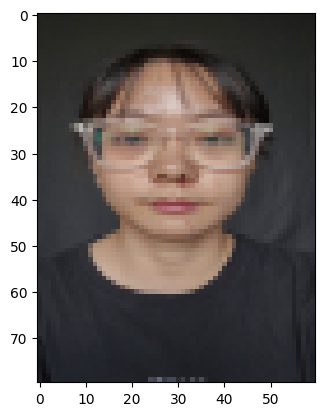

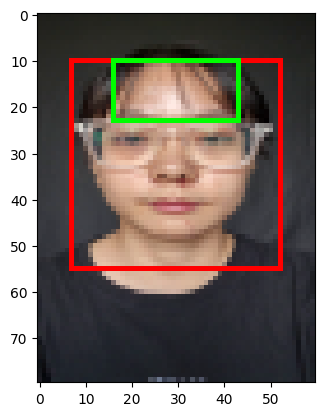

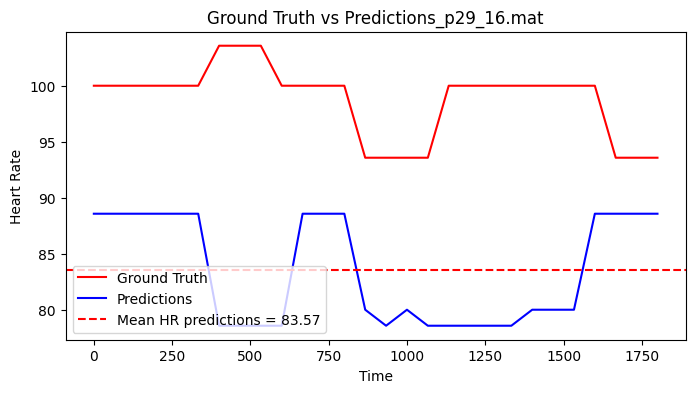

Mean Absolute Error (MAE)_p29_16.mat: 15.306122448979592
Filename: p6_16.mat
First frame:


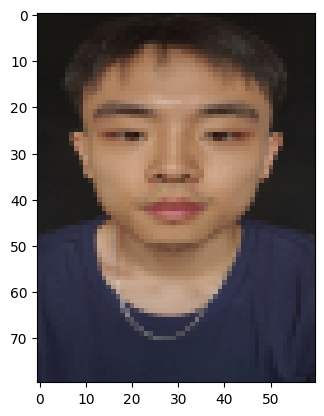

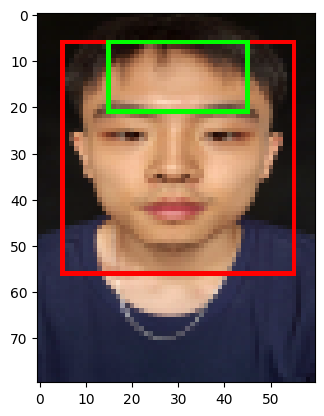

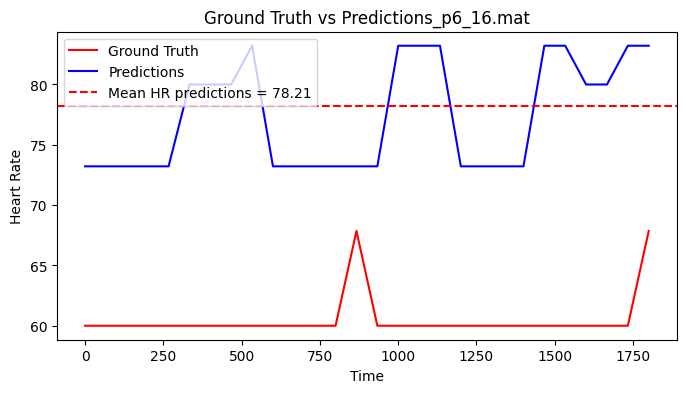

Mean Absolute Error (MAE)_p6_16.mat: 16.7219387755102
Average MAE on all files: 11.75860969387755


In [30]:
import os
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

# Define the directory path
dir_path = './data'

mae_total = []

# Loop over all files in the directory
for filename in os.listdir(dir_path):
    # Check if the file is a regular file (not a directory)
    if os.path.isfile(os.path.join(dir_path, filename)):
        file_path = os.path.join(dir_path, filename)

        print(f"Filename: {filename}")

        # Do something with the file
        sample_file = sio.loadmat(file_path)
        video = sample_file['video']
        gt = sample_file['GT_ppg']

        # Display the first frame
        print("First frame:")
        first_frame = video[0]
        plt.imshow(first_frame)
        plt.show()

        # Get heart rate from gt
        gt = get_heart_rate(gt[0], window_size=180, step_size=60)
        mean_gt = np.mean(gt)

        lower_bound = mean_gt - 5
        upper_bound = mean_gt + 5

        stabilized_gt = np.clip(gt, lower_bound, upper_bound)

        # Get heart rate from predictions
        predictions = predict_hr(video, window_size=180, step_size=60)

        mean_prediction = np.mean(predictions)

        lower_bound = mean_prediction - 5
        upper_bound = mean_prediction + 5

        stabilized_predictions = np.clip(predictions, lower_bound, upper_bound)

        # Calculate the step size for evenly distributing the values
        step_size = len(video) / (len(gt) - 1)

        # Create an array of y-axis values
        y_values = np.arange(0, len(video) + step_size, step_size)

        # Set the plot size
        fig, ax = plt.subplots(figsize=(8, 4))

        # Plot the values
        ax.plot(y_values, stabilized_gt, color='r', label='Ground Truth')
        ax.plot(y_values, stabilized_predictions, color='b', label='Predictions')

        # Plot a horizontal dashed line for the mean value
        ax.axhline(mean_prediction, color='r', linestyle='--', label=f'Mean HR predictions = {mean_prediction:.2f}')

        ax.set_ylabel('Heart Rate')
        ax.set_xlabel('Time')
        ax.legend()
        ax.set_title(f'Ground Truth vs Predictions_{filename}')

        # Show the plot
        plt.show()
        
        # Calculate Mean Absolute Error (MAE)
        mae = mean_absolute_error(stabilized_gt, stabilized_predictions)
        mae_total.append(mae)
        print(f'Mean Absolute Error (MAE)_{filename}: {mae}')

print(f"Average MAE on all files: {np.mean(mae_total)}")